In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from matplotlib.patches import Patch
import ast

In [29]:
# Define paths
# stg_output_trajectory = "/home/emoeller/github/scBONITA2/scBONITA_output/trajectories/atherosclerosis_hsa05417/stg_output"
# trajectory_dir = "/home/emoeller/github/scBONITA2/scBONITA_output/trajectories/atherosclerosis_hsa05417/text_files/cell_trajectories"

stg_output_trajectory = "/home/emoeller/github/scBONITA2/scBONITA_output/trajectories/george_hiv_hsa05417/stg_output"
trajectory_dir = "/home/emoeller/github/scBONITA2/scBONITA_output/trajectories/george_hiv_hsa05417/text_files/cell_trajectories"


# Load state library
state_library_df = pd.read_csv(f"{stg_output_trajectory}/state_library.csv")

# Extract gene names from a sample trajectory file
trajectory_files = [f for f in os.listdir(trajectory_dir) if f.endswith('.csv')]
sample_trajectory = os.path.join(trajectory_dir, trajectory_files[0])

gene_names = []
with open(sample_trajectory, 'r') as f:
    for line in f:
        gene_name = line.strip().split(',')[0]
        gene_names.append(gene_name)

# Load GraphML graph
graphml_path = f"{stg_output_trajectory}/stg_graph_with_similarity.graphml"
G = nx.read_graphml(graphml_path)

# Identify attractors from GraphML
attractor_nodes = []
for node in G.nodes():
    node_data = G.nodes[node]
    if str(node_data.get('is_attractor', 'false')).lower() == 'true':
        attractor_size = int(node_data.get('attractor_size', 0))
        state_str = node_data.get('state', '')
        attractor_nodes.append({
            'state_id': int(node),
            'attractor_size': attractor_size,
            'state': state_str
        })

attractor_nodes_df = pd.DataFrame(attractor_nodes).sort_values('attractor_size', ascending=False)
attractors = state_library_df[state_library_df['is_attractor'] == True].sort_values('cells_reaching', ascending=False)

print(f"Loaded {len(state_library_df)} states, {len(gene_names)} genes")
print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Found {len(attractor_nodes_df)} attractors\n")
print("Top 5 attractors by cell count:")
print(attractor_nodes_df[['state_id', 'attractor_size']].head(5))

Loaded 14490 states, 102 genes
Graph: 14490 nodes, 14552 edges
Found 1500 attractors

Top 5 attractors by cell count:
      state_id  attractor_size
142       4751             117
512       4708              87
1441      4880              54
412       6257              53
1115      4896              52


In [30]:
def visualize_mean_trajectory_to_attractor(attractor_state_id, state_library_df, gene_names, trajectory_dir):
    """
    Visualizes the mean trajectory of all cells leading to a specific attractor.
    
    Parameters
    ----------
    attractor_state_id : int
        The state_id of the attractor to analyze
    state_library_df : pd.DataFrame
        DataFrame containing state library information
    gene_names : list
        List of gene names
    trajectory_dir : str
        Path to directory containing cell trajectory files
    """
    # Load cell-to-attractor mapping
    cell_attractor_df = pd.read_csv(f"{stg_output_trajectory}/cell_attractor_mapping.csv")
    
    # Find all cells that reach this attractor
    cells_to_attractor = cell_attractor_df[cell_attractor_df['attractor_state_id'] == attractor_state_id]
    cell_numbers = cells_to_attractor['cell_number'].values
    
    if len(cell_numbers) == 0:
        print(f"No cells reach attractor {attractor_state_id}")
        return None
    
    print(f"Found {len(cell_numbers)} cells reaching attractor {attractor_state_id}")
    
    # Load all trajectories for these cells
    all_trajectories = []
    
    for cell_num in cell_numbers:
        trajectory_file = os.path.join(trajectory_dir, f"cell_{cell_num}_trajectory.csv")
        
        if os.path.exists(trajectory_file):
            trajectory_data = []
            with open(trajectory_file, 'r') as f:
                for line in f:
                    parts = line.strip().split(',')
                    time_data = [int(i) for i in parts[1:]]  # Skip gene name
                    trajectory_data.append(time_data)
            
            # Convert to numpy array (genes x time_steps)
            trajectory_array = np.array(trajectory_data)
            all_trajectories.append(trajectory_array)
    
    if len(all_trajectories) == 0:
        print(f"No trajectory files found for cells reaching attractor {attractor_state_id}")
        return None
    
    # Stack all trajectories and compute mean across cells
    # Shape: (num_cells, num_genes, num_time_steps)
    stacked_trajectories = np.stack(all_trajectories, axis=0)
    
    # Calculate mean trajectory: (num_genes, num_time_steps)
    mean_trajectory = np.mean(stacked_trajectories, axis=0)
    
    # Create the heatmap
    fig = plt.figure(figsize=(8, 12))
    sns.heatmap(mean_trajectory, cmap='Greys', yticklabels=gene_names, xticklabels=True, vmin=0, vmax=1, cbar=False)
    
    # Get attractor info
    attractor_info = state_library_df[state_library_df['state_id'] == attractor_state_id]
    cells_reaching = attractor_info['cells_reaching'].values[0] if len(attractor_info) > 0 else len(cell_numbers)
    
    plt.title(f'Mean Trajectory to Attractor {attractor_state_id}\n({len(cell_numbers)} cells, {cells_reaching} total reaching)', fontsize=14)
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Genes', fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    
    # Add legend
    legend_elements = [
        Patch(facecolor='lightgrey', edgecolor='grey', label='Gene Inactive (0)'),
        Patch(facecolor='black', edgecolor='black', label='Gene Active (1)'),
        Patch(facecolor='grey', edgecolor='grey', label='Intermediate (0-1)')
    ]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), title="Legend", fontsize=10)
    
    plt.subplots_adjust(top=0.958, bottom=0.07, left=0.076, right=0.85, hspace=2, wspace=1)
    
    return fig

State 4751 info from GraphML:
  Is attractor: True
  Attractor size: 117 cells
Found 117 cells reaching attractor 4751


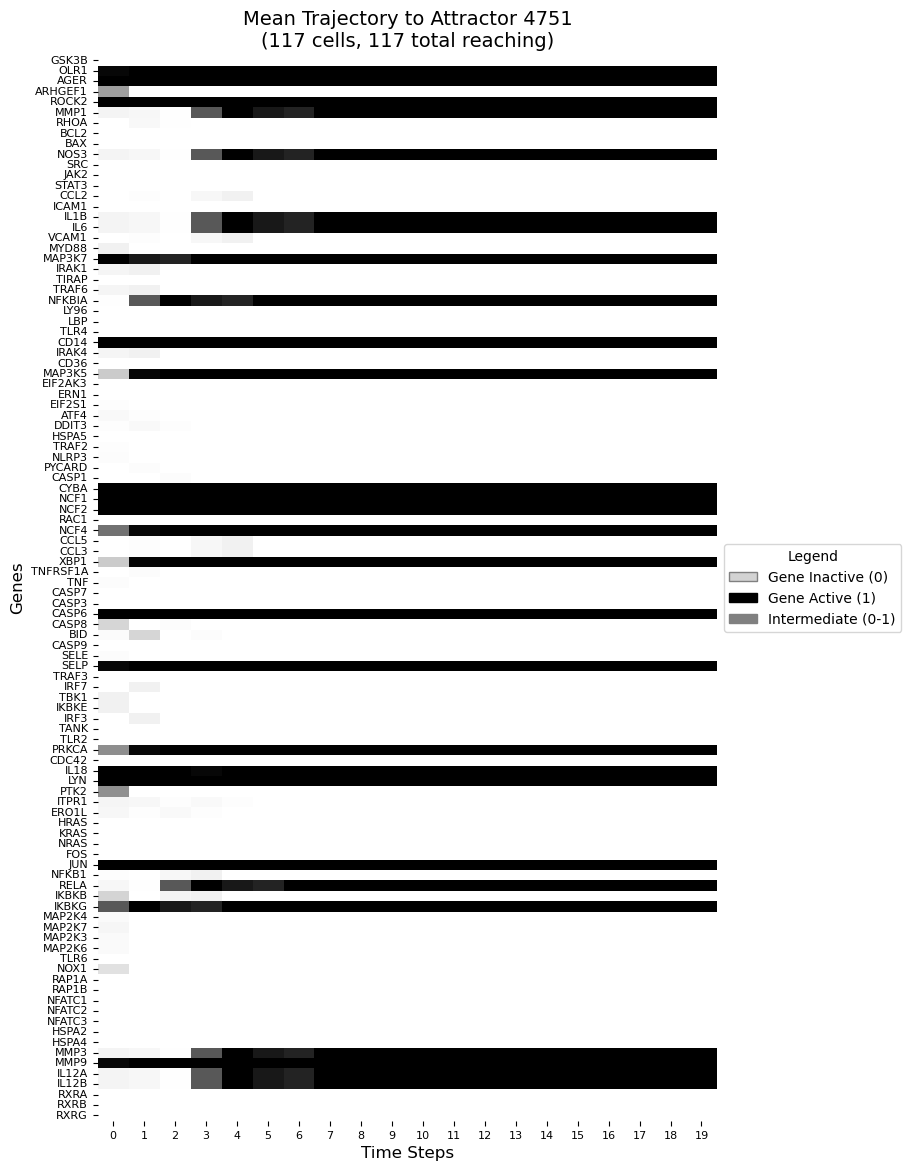

In [39]:
# Visualize mean trajectory to a specific attractor
# Change the state_id below to visualize a different attractor

specific_state_id = 4751

if str(specific_state_id) in G.nodes():
    node_data = G.nodes[str(specific_state_id)]
    print(f"State {specific_state_id} info from GraphML:")
    print(f"  Is attractor: {node_data.get('is_attractor', 'false')}")
    print(f"  Attractor size: {node_data.get('attractor_size', 0)} cells")
    
    fig = visualize_mean_trajectory_to_attractor(specific_state_id, state_library_df, gene_names, trajectory_dir)
    if fig:
        plt.show()
else:
    print(f"State {specific_state_id} not found in GraphML graph")
    print(f"Try one of these attractor IDs: {attractor_nodes_df['state_id'].head(10).tolist()}")